In [ ]:
import numpy as np
import pandas as pd
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
# Updated import path
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Use the updated path
import cv2


from tqdm.notebook import tqdm_notebook as tqdm

import os

In [ ]:
real = "/content/drive/MyDrive/RealFake.zip (Unzipped Files)/real_and_fake_face/training_real/"
fake = "/content/drive/MyDrive/RealFake.zip (Unzipped Files)/real_and_fake_face/training_fake/"

real_path = os.listdir(real)
fake_path = os.listdir(fake)

In [ ]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

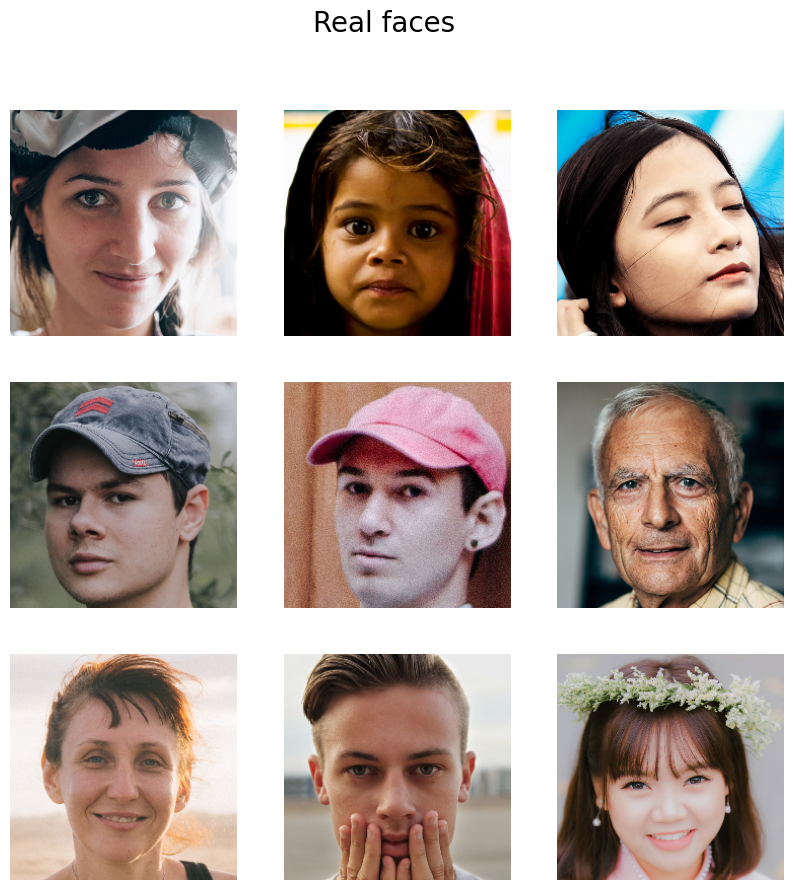

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(load_img(real + real_path[i]), cmap='gray')
    plt.suptitle("Real faces",fontsize=20)
    plt.axis('off')

plt.show()

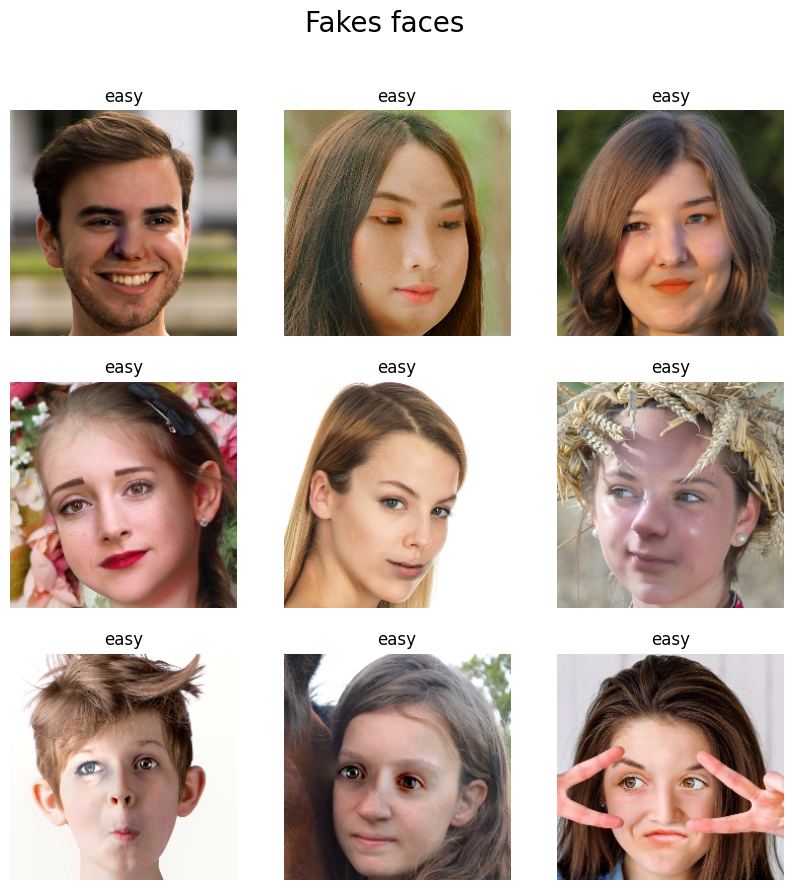

In [ ]:
fig = plt.figure(figsize=(10,10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(load_img(fake + fake_path[i]), cmap='gray')
    plt.suptitle("Fakes faces",fontsize=20)
    plt.title(fake_path[i][:4])
    plt.axis('off')

plt.show()

In [ ]:
dataset_path = "/content/drive/MyDrive/RealFake.zip (Unzipped Files)/real_and_fake_face"

In [ ]:
data_with_aug = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                  validation_split=0.2)

In [ ]:
train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="training")

Found 1633 images belonging to 2 classes.


In [ ]:
val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="validation"
                                          )

Found 408 images belonging to 2 classes.


In [ ]:
mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(96,96,3))

9406464/9406464 [==============================] - 2s 0us/step


In [ ]:
from keras.optimizers import SGD, RMSprop
opt = SGD(learning_rate=0.01)

In [ ]:
tf.keras.backend.clear_session()

model = Sequential([mnet,
            BatchNormalization(),
            Dense(512, activation = "relu"),
            GlobalAveragePooling2D(),

            Dense(256, activation = "relu"),

            Dropout(0.5),

            # Dense(32, activation = "relu"),
            # Dropout(0.3),
            Dense(2, activation = "softmax")])

model.layers[0].trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics="accuracy")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 batch_normalization (Batch  (None, 3, 3, 1280)        5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 3, 3, 512)         655872    
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

In [ ]:
def scheduler(epoch):
    if epoch <= 1:
        return 1.0
    elif epoch > 2 and epoch <= 10:
        return 0.1
    elif epoch > 10 and epoch <= 15:
        return 0.01
    else:
        return 0.001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
hist = model.fit_generator(train,
                    epochs=20,
                    callbacks=[lr_callbacks],
                    validation_data=val)

<ipython-input-14-abeff273e3ad>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train,


Epoch 1/20
52/52 [==============================] - 624s 12s/step - loss: 3.7599 - accuracy: 0.5395 - val_loss: 1.3538 - val_accuracy: 0.5123 - lr: 1.0000
Epoch 2/20
52/52 [==============================] - 19s 367ms/step - loss: nan - accuracy: 0.4930 - val_loss: nan - val_accuracy: 0.4706 - lr: 1.0000
Epoch 3/20
52/52 [==============================] - 19s 369ms/step - loss: nan - accuracy: 0.4703 - val_loss: nan - val_accuracy: 0.4706 - lr: 0.0010
Epoch 4/20
52/52 [==============================] - 19s 373ms/step - loss: nan - accuracy: 0.4703 - val_loss: nan - val_accuracy: 0.4706 - lr: 0.1000
Epoch 5/20
52/52 [==============================] - 19s 372ms/step - loss: nan - accuracy: 0.4703 - val_loss: nan - val_accuracy: 0.4706 - lr: 0.1000
Epoch 6/20
52/52 [==============================] - 19s 372ms/step - loss: nan - accuracy: 0.4703 - val_loss: nan - val_accuracy: 0.4706 - lr: 0.1000
Epoch 7/20
52/52 [==============================] - 19s 373ms/step - loss: nan - accuracy: 0.47

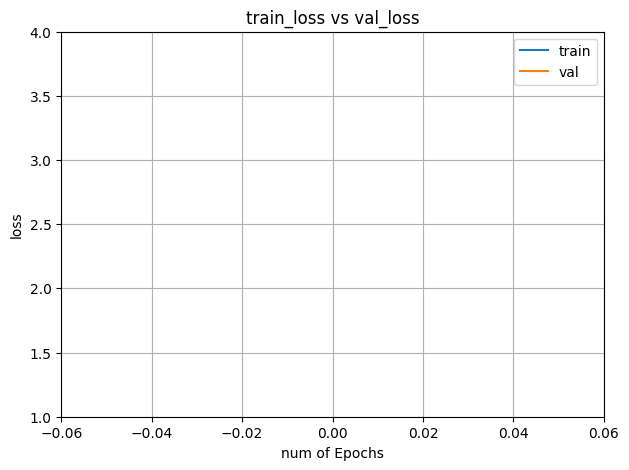

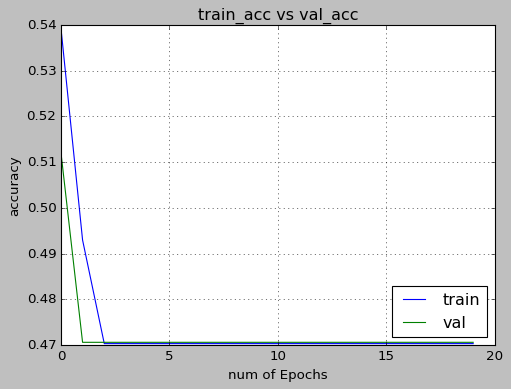

In [ ]:
epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])

plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)

plt.style.use(['classic'])

In [ ]:
#Creating an array of predicted test images

predictions = model.predict_generator(val)

<ipython-input-16-a5c5724c89c6>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(val)


In [ ]:
val_path = "/content/drive/MyDrive/RealFake.zip (Unzipped Files)/real_and_fake_face/"

plt.figure(figsize=(15,15))

start_index = 150

for i in range(16):
  plt.subplot(4,4, i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  preds = np.argmax(predictions[[start_index+i]])

  gt = val.filenames[start_index+i][9:13]


  if gt == "fake":
    gt = 0
  else:
    gt = 1

  if preds != gt:
    col ="r"
  else:
    col = "g"

  plt.xlabel('i={}, pred={}, gt={}'.format(start_index+i,preds,gt),color=col)
  plt.imshow(load_img(val_path+val.filenames[start_index+i]))
  plt.tight_layout()

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/MobileNetV2Deepfake_model.h5')
print("Model saved as 'hybrid_inception_lstm_model.h5'")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as 'hybrid_inception_lstm_model.h5'
